In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lifelines

In [4]:
import main
train = main.load_data(train=True)

In [5]:
train['time_elapsed'] = np.round((train["mth_code"] - train["snapshot"]) / pd.Timedelta(days=30)).astype(int)

In [4]:
# use features that will be available in the test dataset

In [6]:
columns = train.columns.tolist()

In [7]:
hidden_features = [
    "closed",
    "active",
    #"charge_off",
    "charge_off_aged",
    "charge_off_bk",
    "fee_chg_off_reversal_amt",
    "aged_writeoff_amt",
    "bankruptcy_writeoff_amt",
    "fc_reversals",
    "fee_reversals",
    "other_writeoff_amt",
    "writeoff_type_bko",
    "writeoff_type_fraud_kiting",
    "writeoff_type_fraud_synthetic",
    "writeoff_type_deceased",
    "writeoff_type_other",
    "writeoff_type_aged",
    "writeoff_type_settlement",
    "writeoff_type_repo",
    "writeoff_type_null",
    # "mth_code",
    # "snapshot",
]

In [8]:
useful_columns = list(set(columns) - set(hidden_features))

In [9]:
useful_columns.sort()

In [10]:
useful_columns

['account_status_code',
 'active_12_mths',
 'bank_fico_buckets_20',
 'charge_off',
 'charge_off_reason_code',
 'credit_limit_amt',
 'credit_limit_pa',
 'due_account_2',
 'due_account_3',
 'due_account_4',
 'due_account_5',
 'due_account_6',
 'due_account_7',
 'due_account_8',
 'due_balance_2',
 'due_balance_3',
 'due_balance_4',
 'due_balance_5',
 'due_balance_6',
 'due_balance_7',
 'due_balance_8',
 'ever_delinquent_flg',
 'financial_active',
 'fraud_writeoff_amt',
 'industry',
 'mob',
 'mth_code',
 'nbr_mths_due',
 'net_finance_charge',
 'net_payment_behaviour_tripd',
 'net_payments',
 'net_sales',
 'non_principal_amount_gross',
 'non_principal_amount_net',
 'non_principal_amount_stmt',
 'open_closed_flag',
 'prev_balance',
 'principal_amt',
 'principal_amt_chrg_off',
 'promo_bal_amt',
 'promotion_flag',
 'purchase_active',
 'recovery_amt',
 'snapshot',
 'stmt_balance',
 'time_elapsed',
 'total_writeoff_amt',
 'variable_rate_index',
 'variable_rate_margin',
 'writeoff_date',
 'writeo

In [11]:
#convert fico scores into numerical values

In [12]:
def convert_fico(fico_bucket):
    fico_bucket=str(fico_bucket)
    if fico_bucket == '761+':
        return (761+850)/2
    elif fico_bucket == '<= 560':
        return (560+300)/2
    elif fico_bucket == 'Exception' or fico_bucket == 'Missing':
        return np.nan
#        print(fico_bucket)
    else:
        try:
            lower, upper = fico_bucket.split('-')
            return (float(lower)+float(upper))/2
        except Exception as exc:
            print(fico_bucket)
            raise exc

In [13]:
train['fico_score']=train['bank_fico_buckets_20'].apply(lambda df: convert_fico(df))

In [14]:
train['fico_score'].fillna(train['fico_score'].mean(),inplace=True)

In [15]:
#Sample train data to save time on experiments
train_sample = train[useful_columns+['fico_score']].sample(frac=0.1,random_state = 1)

In [16]:
#drop columns with too many nans
nan_features = []
threshold = 0.5
for feature in useful_columns:
    if train_sample[feature].isna().sum()/len(train_sample)>threshold:
        nan_features.append(feature)

In [17]:
nan_features

['charge_off_reason_code', 'variable_rate_margin', 'writeoff_date']

In [18]:
train_sample.drop(nan_features,axis=1,inplace=True)

In [19]:
# compute correlation matrix
train_sample_corr = train_sample.corr()

In [83]:
# features with high correlation with target
abs(train_sample_corr['charge_off']).sort_values(ascending=False).head(20)

charge_off                    1.000000
total_writeoff_amt            0.642990
principal_amt_chrg_off        0.611791
nbr_mths_due                  0.199955
recovery_amt                  0.164052
fico_score                    0.105593
credit_limit_amt              0.056460
prev_balance                  0.048497
financial_active              0.037281
purchase_active               0.024282
promotion_flag                0.022346
active_12_mths                0.021046
fraud_writeoff_amt            0.020044
principal_amt                 0.019874
stmt_balance                  0.019785
credit_limit_pa               0.017554
promo_bal_amt                 0.015017
mob                           0.012031
non_principal_amount_gross    0.010962
due_account_3                 0.010786
Name: charge_off, dtype: float64

In [84]:
#'total_writeoff_amt' and 'principal_amt_chrg_off' is too correlated with the target and will cause divergence
#problem in the CPH fitting process, so we exclude these two features

In [85]:
feature_tochoose = ['nbr_mths_due','fico_score','credit_limit_amt','prev_balance',
                    'financial_active','purchase_active','promotion_flag','active_12_mths']

In [86]:
temp = train_sample[feature_tochoose]
X = (temp-temp.mean())/temp.std()
X['time_elapsed']=train_sample['time_elapsed']
X['charge_off']=train_sample['charge_off']

In [96]:
# To use these numerical features, we find that CPH only converge with a penalizer, but when there is a 
#penalizer, the coefficients are all close to 1, which is hard to inteprete

from lifelines import CoxPHFitter
cph=CoxPHFitter(penalizer = 0.01)
cph.fit(X,duration_col='time_elapsed',event_col='charge_off')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575822 total observations, 574300 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 575822
number of events observed = 1522
   partial log-likelihood = -16184.06
         time fit was run = 2023-03-26 04:27:21 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
nbr_mths_due       0.38       1.47       0.01             0.37             0.39                 1.45                 1.48
fico_score        -0.36       0.70       0.01            -0.38            -0.34                 0.68                 0.71
credit_limit_amt  -0.21       0.81       0.01            -0.24            -0.19                 0.79                 0.83
prev_balance       0.15       1.16       0.01             0.13             0.16                 1.14                 1.18
financial_active   0.13       1.14       0.01             0.11             0.16                 1.12                 1.17
purchase_active   -0.09       0.91       0.01            -0.12            -0.07                 0.89                 0.93
promotion_flag     0.08       1.08       0.01             0.06             0.10                 1.06                 1.11
active_12_mths     0.07       1.07       0.01             0.04             0.09                 1.05                 1.10

                   cmp to      z      p   -log2(p)
covariate                                         
nbr_mths_due         0.00  68.59 <0.005        inf
fico_score           0.00 -33.31 <0.005     805.63
credit_limit_amt     0.00 -17.51 <0.005     225.60
prev_balance         0.00  16.07 <0.005     190.67
financial_active     0.00  11.15 <0.005      93.53
purchase_active      0.00  -7.81 <0.005      47.34
promotion_flag       0.00   6.72 <0.005      35.66
active_12_mths       0.00   5.66 <0.005      26.01
---
Concordance = 0.97
Partial AIC = 32384.11
log-likelihood ratio test = 5072.17 on 8 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

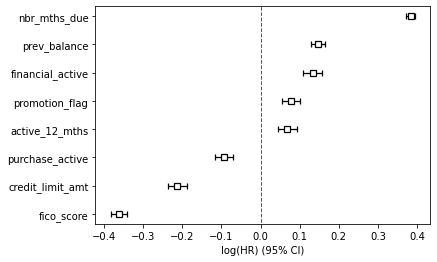

In [97]:
cph.plot()

<AxesSubplot:>

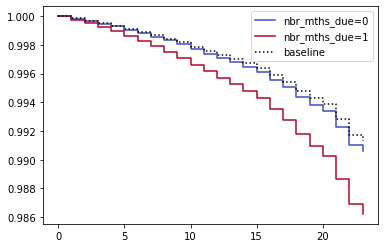

In [98]:
cph.plot_partial_effects_on_outcome(covariates='nbr_mths_due', values=[0, 1], cmap='coolwarm')

In [99]:
# If we use bool variables to encode information as follows

#Also adding a column with low/high (0/1) credit score (using 661 and up as high based off a quick google search)
train_sample['fico_low_high']=train_sample['fico_score'].map(lambda x: 1.0 if x<=660 else 0.0)


#Create column with high/low credit limit amounts (>5000) high
train_sample['credit_limit_high_low']=train_sample['credit_limit_amt'].map(lambda x: 1.0 if x < 5000 else 0.0)

#Creating a column with difference between current balance and previous balance
train_sample['balance_diff']=train_sample['stmt_balance']-train_sample['prev_balance']

#Creating a column with low/high increase in balance from previous statement (high >5000)
train_sample['new_balance_diff_high_low']=train_sample['balance_diff'].map(lambda x: 1.0 if x < 5000 else 0.0)

#Creating column with low/high number of monthly payments due (high >=5)
train_sample['mths_due_high_low']=train_sample['nbr_mths_due'].map(lambda x: 1.0 if x >= 5 else 0.0)

train_sample

,account_status_code,active_12_mths,bank_fico_buckets_20,charge_off,credit_limit_amt,credit_limit_pa,due_account_2,due_account_3,due_account_4,due_account_5,...,time_elapsed,total_writeoff_amt,variable_rate_index,writeoff_type_fraud_other,fico_score,fico_low_high,credit_limit_high_low,balance_diff,new_balance_diff_high_low,mths_due_high_low
5709119,I 25+,False,761+,False,5500.0,0.0,True,True,False,False,...,1,0.0,False,False,805.5,0.0,0.0,-409.57,1.0,0.0
3079101,I 0-6,True,721-740,False,800.0,0.0,False,False,False,False,...,13,0.0,False,False,730.5,0.0,1.0,0.00,1.0,0.0
5588751,I 13-24,True,761+,False,6000.0,0.0,False,False,False,False,...,3,0.0,False,False,805.5,0.0,0.0,-4188.00,1.0,0.0
1604851,I 0-6,True,761+,False,4200.0,0.0,False,False,False,False,...,8,0.0,True,False,805.5,0.0,1.0,629.61,1.0,0.0
531587,A,True,741-760,False,3100.0,0.0,False,False,False,False,...,22,0.0,False,False,750.5,0.0,1.0,-1791.30,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393560,A,True,761+,False,2000.0,0.0,False,False,False,False,...,3,0.0,False,False,805.5,0.0,1.0,2844.90,1.0,0.0
2147812,I 0-6,True,761+,False,2200.0,0.0,False,False,False,False,...,3,0.0,False,False,805.5,0.0,1.0,-287.00,1.0,0.0
5338196,I 7-12,True,581-600,False,5500.0,0.0,False,False,False,False,...,3,0.0,False,False,590.5,1.0,0.0,0.00,1.0,0.0
2243974,A,True,701-720,False,7500.0,0.0,False,False,False,False,...,14,0.0,False,False,710.5,0.0,0.0,-3882.02,1.0,0.0


In [100]:
cph=CoxPHFitter(penalizer = 0)
cph.fit(train_sample[['time_elapsed','charge_off','financial_active','fico_low_high','ever_delinquent_flg','credit_limit_high_low','new_balance_diff_high_low']],duration_col='time_elapsed',event_col='charge_off')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575822 total observations, 574300 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
      baseline estimation = breslow
   number of observations = 575822
number of events observed = 1522
   partial log-likelihood = -16481.24
         time fit was run = 2023-03-26 04:27:36 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
financial_active            2.73      15.33       0.14             2.46             3.00                11.74                20.02
fico_low_high               2.61      13.63       0.06             2.50             2.73                12.12                15.32
ever_delinquent_flg         0.42       1.52       0.07             0.28             0.55                 1.32                 1.74
credit_limit_high_low       2.83      16.98       0.14             2.56             3.11                12.91                22.33
new_balance_diff_high_low   2.12       8.37       0.50             1.14             3.11                 3.14                22.34

                            cmp to     z      p   -log2(p)
covariate                                                 
financial_active              0.00 20.05 <0.005     294.57
fico_low_high                 0.00 43.75 <0.005        inf
ever_delinquent_flg           0.00  5.96 <0.005      28.54
credit_limit_high_low         0.00 20.26 <0.005     300.64
new_balance_diff_high_low     0.00  4.24 <0.005      15.48
---
Concordance = 0.90
Partial AIC = 32972.47
log-likelihood ratio test = 4477.81 on 5 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

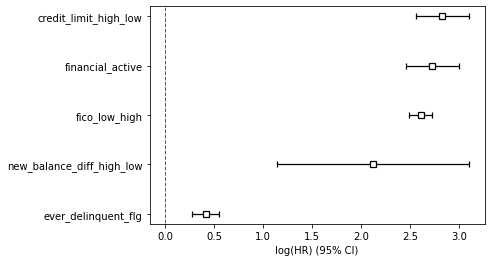

In [101]:
cph.plot()

<AxesSubplot:>

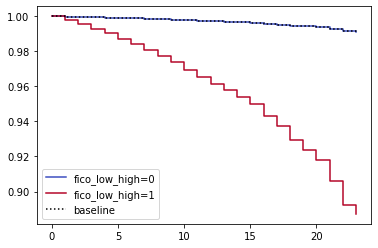

In [102]:
cph.plot_partial_effects_on_outcome(covariates='fico_low_high', values=[0, 1], cmap='coolwarm')

In [118]:
# Incorporate categorical features

In [103]:
cat_vars = ['net_payment_behaviour_tripd','account_status_code','industry']

In [104]:
old_columns = train_sample.columns.to_list()

In [105]:
train_sample_new = train_sample.copy()
for var in cat_vars:
    train_sample_new = pd.concat((train_sample_new, pd.get_dummies(train_sample_new[var],prefix=var)),1)
    train_sample_new = train_sample_new.drop(var,axis = 1)

/var/folders/55/mk0vxtps7kz9rhknst5w8rjr0000gn/T/ipykernel_13300/1607482649.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  train_sample_new = pd.concat((train_sample_new, pd.get_dummies(train_sample_new[var],prefix=var)),1)


In [106]:
new_columns = train_sample_new.columns.tolist()

In [107]:
added_cat_features = list(set(new_columns)- set(old_columns))

In [108]:
net_payment_behaviour_tripd_features = []
account_status_code_features = []
industry_features = []

for column in new_columns:
    if column.startswith('net_payment_behaviour_tripd'):
        net_payment_behaviour_tripd_features.append(column)
    elif column.startswith('account_status_code'):
        account_status_code_features.append(column)
    elif column.startswith('industry'):
        industry_features.append(column)
net_payment_behaviour_tripd_features,account_status_code_features,industry_features

(['net_payment_behaviour_tripd_C',
  'net_payment_behaviour_tripd_D',
  'net_payment_behaviour_tripd_I',
  'net_payment_behaviour_tripd_P',
  'net_payment_behaviour_tripd_R',
  'net_payment_behaviour_tripd_T'],
 ['account_status_code_A',
  'account_status_code_I 0-6',
  'account_status_code_I 13-24',
  'account_status_code_I 25+',
  'account_status_code_I 7-12',
  'account_status_code_MonthEnd',
  'account_status_code_Recovery',
  'account_status_code_W',
  'account_status_code_Clchange'],
 ['industry_A', 'industry_B', 'industry_C'])

In [109]:
net_payment_behaviour_tripd_features_deleted = net_payment_behaviour_tripd_features.pop()
account_status_code_features_deleted = account_status_code_features.pop()
industry_deleted = industry_features.pop()

In [110]:
net_payment_behaviour_tripd_features,account_status_code_features,industry_features

(['net_payment_behaviour_tripd_C',
  'net_payment_behaviour_tripd_D',
  'net_payment_behaviour_tripd_I',
  'net_payment_behaviour_tripd_P',
  'net_payment_behaviour_tripd_R'],
 ['account_status_code_A',
  'account_status_code_I 0-6',
  'account_status_code_I 13-24',
  'account_status_code_I 25+',
  'account_status_code_I 7-12',
  'account_status_code_MonthEnd',
  'account_status_code_Recovery',
  'account_status_code_W'],
 ['industry_A', 'industry_B'])

In [39]:
# Without a penalizer, CPH only converges when including industry_features
cph=CoxPHFitter()
cph.fit(train_sample_new[['time_elapsed','charge_off','financial_active','fico_low_high','ever_delinquent_flg','credit_limit_high_low','new_balance_diff_high_low']+industry_features],duration_col='time_elapsed',event_col='charge_off')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575822 total observations, 574300 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
      baseline estimation = breslow
   number of observations = 575822
number of events observed = 1522
   partial log-likelihood = -16414.29
         time fit was run = 2023-03-26 02:52:34 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
financial_active            2.72      15.25       0.14             2.46             2.99                11.68                19.91
fico_low_high               2.61      13.58       0.06             2.49             2.73                12.08                15.27
ever_delinquent_flg         0.42       1.53       0.07             0.29             0.56                 1.33                 1.75
credit_limit_high_low       2.83      16.91       0.14             2.55             3.10                12.86                22.24
new_balance_diff_high_low   2.12       8.29       0.50             1.13             3.10                 3.11                22.12
industry_A                  0.59       1.80       0.08             0.44             0.74                 1.55                 2.09
industry_B                 -0.07       0.94       0.07            -0.21             0.08                 0.81                 1.08

                            cmp to     z      p   -log2(p)
covariate                                                 
financial_active              0.00 20.01 <0.005     293.45
fico_low_high                 0.00 43.70 <0.005        inf
ever_delinquent_flg           0.00  6.06 <0.005      29.48
credit_limit_high_low         0.00 20.23 <0.005     299.79
new_balance_diff_high_low     0.00  4.23 <0.005      15.35
industry_A                    0.00  7.61 <0.005      45.00
industry_B                    0.00 -0.90   0.37       1.44
---
Concordance = 0.91
Partial AIC = 32842.57
log-likelihood ratio test = 4611.71 on 7 df
-log2(p) of ll-ratio test = inf

In [119]:
# Without a penalizer, CPH only converges when including industry_features
cph=CoxPHFitter(penalizer=0.001)
cph.fit(train_sample_new[feature_tochoose+industry_features+['time_elapsed','charge_off']],duration_col='time_elapsed',event_col='charge_off')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575822 total observations, 574300 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 575822
number of events observed = 1522
   partial log-likelihood = -14265.57
         time fit was run = 2023-03-26 04:36:30 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
nbr_mths_due       0.61       1.84       0.01             0.59             0.63                 1.80                 1.88
fico_score        -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
credit_limit_amt  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
prev_balance       0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
financial_active   0.99       2.70       0.06             0.88             1.11                 2.41                 3.03
purchase_active   -0.95       0.39       0.08            -1.11            -0.80                 0.33                 0.45
promotion_flag     0.42       1.52       0.04             0.33             0.51                 1.39                 1.66
active_12_mths     0.69       1.99       0.08             0.53             0.84                 1.70                 2.32
industry_A         0.27       1.31       0.06             0.16             0.38                 1.17                 1.46
industry_B        -0.14       0.87       0.05            -0.24            -0.04                 0.78                 0.96

                   cmp to      z      p   -log2(p)
covariate                                         
nbr_mths_due         0.00  54.65 <0.005        inf
fico_score           0.00 -44.43 <0.005        inf
credit_limit_amt     0.00 -28.72 <0.005     600.34
prev_balance         0.00  23.57 <0.005     405.70
financial_active     0.00  17.15 <0.005     216.69
purchase_active      0.00 -12.23 <0.005     111.92
promotion_flag       0.00   9.33 <0.005      66.32
active_12_mths       0.00   8.66 <0.005      57.54
industry_A           0.00   4.72 <0.005      18.70
industry_B           0.00  -2.72   0.01       7.26
---
Concordance = 0.99
Partial AIC = 28551.13
log-likelihood ratio test = 8909.15 on 10 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

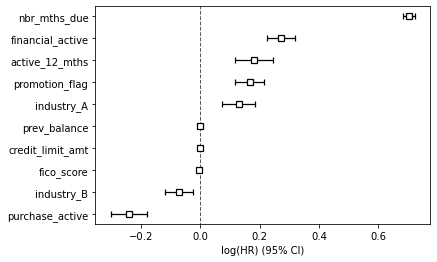

In [117]:
cph.plot()

<AxesSubplot:>

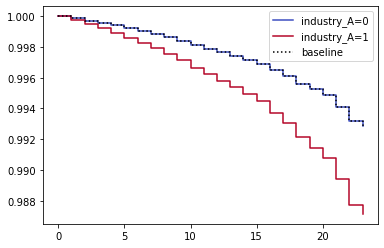

In [41]:
cph.plot_partial_effects_on_outcome(covariates='industry_A', values=[0, 1], cmap='coolwarm')

# Macro data

In [42]:
macro_data = pd.read_csv('macro_data.csv')

In [43]:
macro_data.head(10)

,Mnemonic,M_FHOFHOPIPOQ.IUSA,M_FYLE.IUSA,M_FRT.IUSA,M_FYPSAVQ.IUSA,M_FC.IUSA,FYPCPICA_FEDB.IUSA,M_FGDP.IUSA,M_FYHHAVGQ.IUSA,M_FYFMMEDQ.IUSA,...,M_FBCFCOFCCQ.IUSA,M_FETP.IUSA,M_FLTV.IUSA,M_FC$.IUSA,M_FEIAMGTTQ.IUSA,M_FXCPMGASUQ.IUSA,M_FRBBBQ.IUSA,M_FHOWNRQ.IUSA,M_FIFR_FEDS.IUSA,M_FIFR$_FEDS.IUSA
0,Description,Baseline Scenario (October 2022): FHFA Purchas...,Baseline Scenario (October 2022): NIPA: Income...,Baseline Scenario (October 2022): Retail Sales...,Baseline Scenario (October 2022): Income: Pers...,Baseline Scenario (October 2022): NIPA: Person...,Baseline Scenario (October 2022): Income: Per ...,Baseline Scenario (October 2022): NIPA: Gross ...,Baseline Scenario (October 2022): Average Hous...,Baseline Scenario (October 2022): Median Famil...,...,Baseline Scenario (June 2020): Charge Off Rate...,Baseline Scenario (June 2020): Employment: Tot...,Baseline Scenario (June 2020): Terms Conventio...,Baseline Scenario (June 2020): NIPA: Personal ...,Baseline Scenario (June 2020): U.S. All Grades...,Baseline Scenario (June 2020): Motor gasoline ...,Baseline Scenario (June 2020): Merrill Lynch 1...,Baseline Scenario (June 2020): Homeownership R...,FRB CCAR 2020 - Severely Adverse: NIPA: Fixed ...,FRB CCAR 2020 - Severely Adverse: NIPA: Fixed ...
1,Name,"FHFA Purchase-Only Home Price Index, (Index 19...","NIPA: Income - Compensation of Employees, (Bil...","Retail Sales - Retail Sales Total, (Bil. USD, ...","Income: Personal - Saving Rate, (%, SA)",NIPA: Personal Consumption Expenditures - Tota...,"Income: Per Capita Income, (USD)","NIPA: Gross Domestic Product, (Bil. USD, SAAR)","Average Household Income: All Races, (USD, SA)","Median Family Income: All Races, (USD, SA)",...,Charge Off Rates: All Commercial Banks - Credi...,"Employment: Total Private, (Mil. #, SA)",Terms Conventional Mortgages: All Loans - Comp...,NIPA: Personal Consumption Expenditures - Tota...,U.S. All Grades All Formulations Retail Gasoli...,"Motor gasoline prices: Unleaded, (Cents per ga...","Merrill Lynch 10-Year Bbb Corporate Bond Rate,...","Homeownership Rate, (%, SA)","NIPA: Fixed Investment - Residential - Total, ...","NIPA: Fixed Investment - Residential - Total, ..."
2,Source,U.S. Federal Housing Finance Agency (FHFA); Fr...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Census Bureau (BOC); Moody's Analytics Fo...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Census Bureau (BOC); U.S. Bureau of Econo...,U.S. Census Bureau (BOC); Moody's Analytics Fo...,...,U.S. Board of Governors of the Federal Reserve...,U.S. Bureau of Labor Statistics (BLS); Moody's...,U.S. Federal Housing Finance Board (FHFB); Moo...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Energy Information Administration (EIA); ...,Oil Price Information Service (OPIS); Moody's ...,U.S. Board of Governors of the Federal Reserve...,U.S. Census Bureau (BOC); Moody's Analytics Fo...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...
3,Native Frequency,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,ANNUAL,MONTHLY,MONTHLY,MONTHLY,...,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY
4,Geography,United States,United States,United States,United States,United States,United States,United States,United States,United States,...,United States,United States,United States,United States,United States,United States,United States,United States,United States,United States
5,Last Updated,10/11/2022,10/11/2022,10/11/2022,10/11/2022,10/11/2022,10/10/2022,10/11/2022,10/11/2022,10/11/2022,...,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,2/8/2020,2/8/2020
6,Historical End Date,7/31/2022,8/31/2022,8/31/2022,8/31/2022,8/31/2022,12/31/2020,6/30/2022,6/30/2020,3/31/2022,...,12/31/2019,5/31/2020,4/30/2019,4/30/2020,5/31/2020,5/31/2020,9/30/2018,3/31

In [44]:
train_mth_code = train[['mth_code','charge_off']].groupby('mth_code').sum()/train[['mth_code','charge_off']].groupby('mth_code').count()

In [45]:
# data starts from row 7
macro_data_clean = macro_data.iloc[7:,:]

In [46]:
macro_data_clean['date']=pd.to_datetime(macro_data_clean['Mnemonic'])

/var/folders/55/mk0vxtps7kz9rhknst5w8rjr0000gn/T/ipykernel_13300/124077277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macro_data_clean['date']=pd.to_datetime(macro_data_clean['Mnemonic'])


In [47]:
macro_data_clean['mth_code']=pd.DatetimeIndex(macro_data_clean['date']) + pd.DateOffset(1)

/var/folders/55/mk0vxtps7kz9rhknst5w8rjr0000gn/T/ipykernel_13300/3999989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macro_data_clean['mth_code']=pd.DatetimeIndex(macro_data_clean['date']) + pd.DateOffset(1)


In [48]:
train_macro_combined = train_mth_code.merge(macro_data_clean,on='mth_code').drop(['Mnemonic','date'],axis=1)

In [49]:
train_macro_combined

,mth_code,charge_off,M_FHOFHOPIPOQ.IUSA,M_FYLE.IUSA,M_FRT.IUSA,M_FYPSAVQ.IUSA,M_FC.IUSA,FYPCPICA_FEDB.IUSA,M_FGDP.IUSA,M_FYHHAVGQ.IUSA,...,M_FBCFCOFCCQ.IUSA,M_FETP.IUSA,M_FLTV.IUSA,M_FC$.IUSA,M_FEIAMGTTQ.IUSA,M_FXCPMGASUQ.IUSA,M_FRBBBQ.IUSA,M_FHOWNRQ.IUSA,M_FIFR_FEDS.IUSA,M_FIFR$_FEDS.IUSA
0,2018-01-01,0.000000,247.1112727,10714.677,5209.548,6.3,13609.029,52856.89199,20034.78511,137521.2505,...,3.672077917,125.17,79,12785.503,2.59375,248.2625,3.938416142,64.07549477,782.3258391,621.1330721
1,2018-02-01,0.001964,248.873161,10761.294,5181.42,7.1,13628.374,53049.86599,20073.62463,138178.1894,...,3.664279275,125.317,79.5,12775.504,2.6712,253.46,4.058025114,64.18299722,782.9992665,616.3053138
2,2018-03-01,0.002724,250.8678133,10780.022,5215.572,7.2,13668.318,53233.38442,20141.45839,138578.5727,...,3.65003925,125.672,79.3,12765.158,2.70475,256.9375,4.206673162,64.29943946,783.2181714,611.3780129
3,2018-04-01,0.002604,251.6692577,10808.394,5198.868,7.2,13735.355,53417.1033,20251.37579,139015.1391,...,3.635682638,125.85,79.2,12808.044,2.709,255.9775,4.374298511,64.41750914,784.8495621,608.5116733
4,2018-05-01,0.002978,252.3962837,10850.006,5220.732,7.2,13792.129,53607.57795,20361.7524,139415.5111,...,3.627843586,125.977,79.2,12863.202,2.8732,272.104,4.530713379,64.50872796,787.5053156,607.2579171
5,2018-06-01,0.003063,253.7272947,10884.605,5277.108,7.2,13860.171,53798.93234,20482.75073,139951.8411,...,3.634637848,126.238,78.9,12918.212,2.98675,290.12,4.625637301,64.52811155,789.9358207,606.4957157
6,2018-07-01,0.002711,254.8264638,10938.375,5250.324,7.4,13900.213,53991.49272,20566.09014,140544.0184,...,3.65751949,126.429,78.7,12946.163,2.9695,292.225,4.637646914,64.46222344,791.1338637,605.1493672
7,2018-08-01,0.002746,255.8970963,11000.556,5285.064,7.5,13952.254,54185.6046,20646.54348,141261.2749,...,3.680372944,126.562,79,12992.581,2.9278,288.464,4.6120216,64.37585739,790.9165229,603.0620194
8,2018-09-01,0.002700,257.1583704,11056.842,5278.512,7.6,14001.103,54384.72451,20705.33069,141810.1233,...,3.68101517,126.778,78.8,13035.279,2.91425,287.6625,4.617717228,64.3609134,789.3029976,600.2356039
9,2018-10-01,0.003155,257.5543485,11071.396,5272.152,7.7,14013.025,54582.57541,20709.96619,141969.5417,...,3.648614399,126.859,78,13031.547,2.91475,287.245,4.696259379,64.46533689,786.7324795,597.0563768


In [50]:
index_features = list(set(train_macro_combined.columns.to_list()) - set(['mth_code','charge_off']))

In [51]:
train_macro_combined[index_features]=train_macro_combined[index_features].astype(np.float64)

In [52]:
#Compute mutual information of columns of financial index with charge_off frequency
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

X=train_macro_combined.copy()
X.drop(['mth_code'],axis=1,inplace=True)
y=X.pop('charge_off')
X=X.astype(np.float64)


mi_scores = make_mi_scores(X, y)
mi_scores[:3]  # show a few features with their MI scores

M_FRBAAC.IUSA      0.539817
M_FRBBBQ.IUSA      0.537488
M_FYHHMEDQ.IUSA    0.466288
Name: MI Scores, dtype: float64

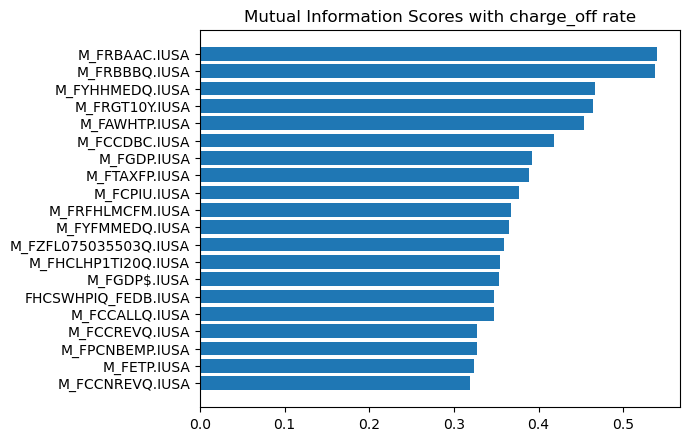

In [78]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores with charge_off rate")


ax1 = plt.figure(dpi=100, figsize=(8, 5))
plt.gcf().subplots_adjust(left=0.3)
plot_mi_scores(mi_scores[:20])

In [79]:
ax1.get_figure().savefig("MI.png")

In [267]:
# Thus we add the M_FRBAAC.IUSA and M_FRBBBQ.IUSA columns in the training data

In [58]:
macro_features = ['M_FRBAAC.IUSA','M_FRBBBQ.IUSA']

In [59]:
macro_to_train = train_macro_combined[['mth_code']+macro_features]

In [60]:
macro_to_train

,mth_code,M_FRBAAC.IUSA,M_FRBBBQ.IUSA
0,2018-01-01,4.223500,3.938416
1,2018-02-01,4.256190,4.058025
2,2018-03-01,4.508947,4.206673
3,2018-04-01,4.640000,4.374299
4,2018-05-01,4.669048,4.530713
5,2018-06-01,4.825455,4.625637
6,2018-07-01,4.834762,4.637647
7,2018-08-01,4.791429,4.612022
8,2018-09-01,4.766087,4.617717
9,2018-10-01,4.883684,4.696259


In [122]:
train_sample_final = train_sample_new.merge(macro_to_train,on='mth_code')

In [123]:
#train_final = train.merge(macro_to_train,on='mth_code')

In [124]:
cph=CoxPHFitter()
cph.fit(train_sample_final[['time_elapsed','charge_off','financial_active','fico_low_high','ever_delinquent_flg','credit_limit_high_low','new_balance_diff_high_low']+industry_features+macro_features],duration_col='time_elapsed',event_col='charge_off')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575822 total observations, 574300 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
      baseline estimation = breslow
   number of observations = 575822
number of events observed = 1522
   partial log-likelihood = -16241.88
         time fit was run = 2023-03-26 04:39:28 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
financial_active            2.70      14.91       0.14             2.44             2.97                11.42                19.47
fico_low_high               2.61      13.59       0.06             2.49             2.73                12.09                15.28
ever_delinquent_flg         0.41       1.51       0.07             0.28             0.55                 1.32                 1.73
credit_limit_high_low       2.83      16.92       0.14             2.55             3.10                12.86                22.25
new_balance_diff_high_low   2.10       8.18       0.50             1.12             3.08                 3.07                21.82
industry_A                  0.59       1.81       0.08             0.44             0.74                 1.55                 2.10
industry_B                 -0.05       0.95       0.07            -0.20             0.09                 0.82                 1.10
M_FRBAAC.IUSA              -0.18       0.84       0.18            -0.53             0.18                 0.59                 1.20
M_FRBBBQ.IUSA               1.28       3.59       0.18             0.92             1.63                 2.52                 5.11

                            cmp to     z      p   -log2(p)
covariate                                                 
financial_active              0.00 19.84 <0.005     288.70
fico_low_high                 0.00 43.71 <0.005        inf
ever_delinquent_flg           0.00  5.92 <0.005      28.21
credit_limit_high_low         0.00 20.23 <0.005     299.88
new_balance_diff_high_low     0.00  4.20 <0.005      15.18
industry_A                    0.00  7.66 <0.005      45.56
industry_B                    0.00 -0.73   0.47       1.10
M_FRBAAC.IUSA                 0.00 -0.97   0.33       1.60
M_FRBBBQ.IUSA                 0.00  7.08 <0.005      39.34
---
Concordance = 0.92
Partial AIC = 32501.77
log-likelihood ratio test = 4956.52 on 9 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

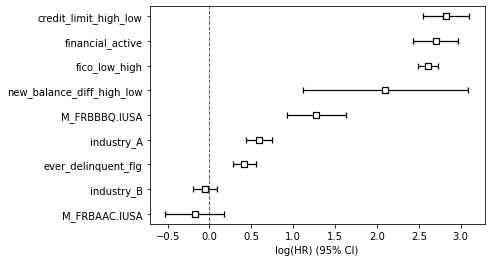

In [125]:
cph.plot()

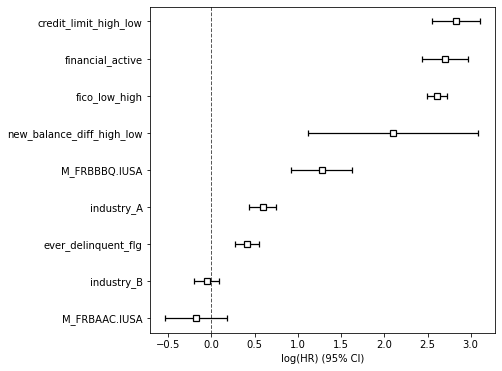

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.gcf().subplots_adjust(left=0.3)
ax2 = cph.plot()
ax2.get_figure().savefig("CPH.jpeg")

In [274]:
macro_to_train['M_FRBAAC.IUSA'].max(), macro_to_train['M_FRBAAC.IUSA'].min()

(5.224, 3.873636364)

<AxesSubplot:>

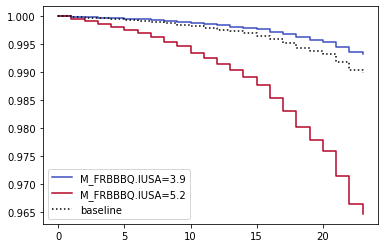

In [275]:
cph.plot_partial_effects_on_outcome(covariates='M_FRBBBQ.IUSA',values=[3.9, 5.2], cmap='coolwarm')

In [81]:
import pickle
import pathlib
pathlib.Path("cph.pkl").write_bytes(pickle.dumps(cph))

42618915

In [126]:
#train on the full train set

In [127]:
train_new = train.copy()
for var in cat_vars:
    train_new = pd.concat((train_new, pd.get_dummies(train_new[var],prefix=var)),1)
    train_new = train_new.drop(var,axis = 1)

/var/folders/55/mk0vxtps7kz9rhknst5w8rjr0000gn/T/ipykernel_13300/4074028973.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  train_new = pd.concat((train_new, pd.get_dummies(train_new[var],prefix=var)),1)


In [128]:
# If we use bool variables to encode information as follows

#Also adding a column with low/high (0/1) credit score (using 661 and up as high based off a quick google search)
train_new['fico_low_high']=train_new['fico_score'].map(lambda x: 1.0 if x<=660 else 0.0)


#Create column with high/low credit limit amounts (>5000) high
train_new['credit_limit_high_low']=train_new['credit_limit_amt'].map(lambda x: 1.0 if x < 5000 else 0.0)

#Creating a column with difference between current balance and previous balance
train_new['balance_diff']=train_new['stmt_balance']-train_new['prev_balance']

#Creating a column with low/high increase in balance from previous statement (high >5000)
train_new['new_balance_diff_high_low']=train_new['balance_diff'].map(lambda x: 1.0 if x < 5000 else 0.0)

#Creating column with low/high number of monthly payments due (high >=5)
train_new['mths_due_high_low']=train_new['nbr_mths_due'].map(lambda x: 1.0 if x >= 5 else 0.0)

train_new

,financial_active,promotion_flag,variable_rate_index,active_12_mths,bank_fico_buckets_20,charge_off_reason_code,mob,open_closed_flag,ever_delinquent_flg,nbr_mths_due,...,account_status_code_W,account_status_code_Clchange,industry_A,industry_B,industry_C,fico_low_high,credit_limit_high_low,balance_diff,new_balance_diff_high_low,mths_due_high_low
0,True,False,False,True,581-600,NaN,3,1.0,False,0,...,0,0,0,1,0,1.0,0.0,-1883.55,1.0,0.0
1,False,False,False,True,721-740,NaN,159,1.0,False,0,...,0,0,0,0,1,0.0,0.0,0.00,1.0,0.0
2,True,False,False,True,761+,NaN,22,1.0,False,0,...,0,0,1,0,0,0.0,1.0,0.00,1.0,0.0
3,True,False,True,True,761+,NaN,16,1.0,True,0,...,0,0,0,1,0,0.0,1.0,0.00,1.0,0.0
4,True,False,False,False,721-740,NaN,3,1.0,False,2,...,0,0,0,1,0,0.0,1.0,0.00,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5758218,False,True,False,True,641-660,NaN,41,1.0,False,0,...,0,0,1,0,0,1.0,1.0,-787.52,1.0,0.0
5758219,True,True,False,True,701-720,NaN,47,1.0,False,0,...,0,0,0,0,1,0.0,1.0,-178.03,1.0,0.0
5758220,True,True,False,True,741-760,NaN,34,1.0,False,0,...,0,0,0,1,0,0.0,0.0,-3800.00,1.0,0.0
5758221,False,True,False,True,681-700,NaN,50,1.0,False,0,...,0,0,0,1,0,0.0,1.0,-12758.19,1.0,0.0


In [129]:
train_final = train_new.merge(macro_to_train,on='mth_code')

In [130]:
cph=CoxPHFitter()
cph.fit(train_final[['time_elapsed','charge_off','financial_active','fico_low_high','ever_delinquent_flg','credit_limit_high_low','new_balance_diff_high_low']+industry_features+macro_features],duration_col='time_elapsed',event_col='charge_off')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5.75822e+06 total observations, 5.74252e+06 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
      baseline estimation = breslow
   number of observations = 5.75822e+06
number of events observed = 15698
   partial log-likelihood = -203916.18
         time fit was run = 2023-03-26 04:54:37 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
financial_active            2.72      15.16       0.04             2.63             2.80                13.94                16.48
fico_low_high               2.67      14.43       0.02             2.63             2.71                13.91                14.98
ever_delinquent_flg         0.45       1.57       0.02             0.41             0.50                 1.51                 1.64
credit_limit_high_low       2.56      13.00       0.04             2.49             2.64                12.05                14.02
new_balance_diff_high_low   1.80       6.08       0.13             1.54             2.06                 4.69                 7.88
industry_A                  0.60       1.82       0.02             0.55             0.64                 1.73                 1.90
industry_B                 -0.01       0.99       0.02            -0.06             0.03                 0.94                 1.03
M_FRBAAC.IUSA               0.01       1.01       0.06            -0.10             0.12                 0.91                 1.13
M_FRBBBQ.IUSA               1.12       3.07       0.06             1.01             1.23                 2.76                 3.43

                            cmp to      z      p   -log2(p)
covariate                                                  
financial_active              0.00  63.65 <0.005        inf
fico_low_high                 0.00 141.19 <0.005        inf
ever_delinquent_flg           0.00  21.17 <0.005     328.05
credit_limit_high_low         0.00  66.59 <0.005        inf
new_balance_diff_high_low     0.00  13.60 <0.005     137.50
industry_A                    0.00  24.50 <0.005     437.90
industry_B                    0.00  -0.49   0.62       0.68
M_FRBAAC.IUSA                 0.00   0.25   0.80       0.32
M_FRBBBQ.IUSA                 0.00  20.14 <0.005     297.36
---
Concordance = 0.92
Partial AIC = 407850.35
log-likelihood ratio test = 51239.47 on 9 df
-log2(p) of ll-ratio test = inf

In [131]:
import pickle
import pathlib
pathlib.Path("cph_full.pkl").write_bytes(pickle.dumps(cph))

426116589

<AxesSubplot:xlabel='log(HR) (95% CI)'>

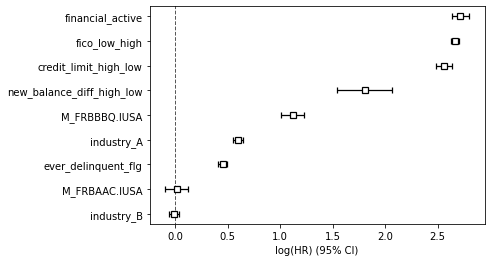

In [132]:
cph.plot()